<a href="https://colab.research.google.com/github/ZyLiao-0011/NX414/blob/main/data_driven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.nn import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd
import h5py
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/nx414')
from utils import load_it_data, visualize_img

In [4]:
path_to_data = '/content/drive/MyDrive/nx414' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [5]:
class SpikeData(Dataset):
    def __init__(self,stimulus,spike = None):
        self.stimulus = torch.tensor(stimulus)

        if spike is not None:
          self.spike = torch.tensor(spike)
          self.num_neuron = self.spike.shape[1]
        else:
          self.spike = None
          self.num_neuron = None

    def __len__(self):
        return len(self.stimulus)

    def __getitem__(self, idx):
        return self.stimulus[idx], self.spike[idx]

In [6]:
ITdataloader_train = DataLoader(SpikeData(stimulus_train, spikes_train), batch_size=32, shuffle=True)
ITdataloader_val = DataLoader(SpikeData(stimulus_val, spikes_val), batch_size=32, shuffle=False)
ITdataloader_test = DataLoader(SpikeData(stimulus_test,spike = None), batch_size=32, shuffle=False)

In [7]:
class ShallowCNN(nn.Module):
    def __init__(self,num_neuron):
        super(ShallowCNN, self).__init__()

        # Conv block 1
        self.convblock1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(16),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 2
        self.convblock2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Conv block 3
        self.convblock3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU6(),
                                        nn.MaxPool2d(kernel_size=2))

        # Adaptive flatten to work for 224x224 input images
        self.flatten = nn.Flatten()

        # Calculate the size of the feature map after conv blocks
        # For 224x224 input -> 112 -> 56 -> 28 after 3 maxpools
        conv_output_size = 64 * (224 // 8) * (224 // 8)  # 64 channels, 28x28 feature map

        self.fc1 = nn.Linear(conv_output_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_neuron)  # Output = num_neuron = 168


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    @staticmethod # defines that the following function does not take self as input
    @torch.no_grad() # ensures that following function runs without tracking gradients
    # making the initialisation faster and more memory-efficient. The parameters remain trainable.
    def init_weights(module):
        # YOUR CODE HERE
        # raise NotImplementedError()

        # He initialization
        # Conv2d layers
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        # Linear layers
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            nn.init.zeros_(module.bias)

        # Initialize BatchNorm weights to 1 and bias to 0
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for stimulus, spikes in train_loader:
                stimulus, spikes = stimulus.to(device), spikes.to(device)
                outputs = model(stimulus)

                optimizer.zero_grad()
                loss = criterion(outputs, spikes)
                running_loss += loss.item()
                loss.backward()
                optimizer.step()

                pbar.set_postfix(loss=running_loss/len(train_loader))
                pbar.update(1)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stimulus, labels in val_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")



In [9]:
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2, scheduler=None):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for stimulus, spikes in train_loader:
                stimulus, spikes = stimulus.to(device), spikes.to(device)
                optimizer.zero_grad()

                outputs = model(stimulus)
                loss = criterion(outputs, spikes)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (pbar.n + 1))
                pbar.update(1)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for stimulus, labels in val_loader:
                stimulus, labels = stimulus.to(device), labels.to(device)
                outputs = model(stimulus)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        if scheduler:
            scheduler.step()

    model.load_state_dict(best_model_wts)
    return model

In [19]:
loss_fn = nn.MSELoss()
model = ShallowCNN(num_neuron=168)
model.apply(ShallowCNN.init_weights)
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.005, weight_decay=1e-5)
train_model(model, ITdataloader_train, ITdataloader_val, loss_fn, optimizer, num_epochs=500)

save_path = '/content/drive/MyDrive/nx414/shallow_cnn.pth'
torch.save(model.state_dict(), save_path)

Epoch 1/500: 100%|██████████| 81/81 [00:02<00:00, 36.93it/s, loss=734]


Epoch [1/500], Train Loss: 734.1971
Validation Loss: 22.6792


Epoch 2/500: 100%|██████████| 81/81 [00:02<00:00, 36.98it/s, loss=34.2]


Epoch [2/500], Train Loss: 34.2427
Validation Loss: 11.0156


Epoch 3/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=19.7]


Epoch [3/500], Train Loss: 19.7129
Validation Loss: 7.0713


Epoch 4/500: 100%|██████████| 81/81 [00:02<00:00, 36.90it/s, loss=13.1]


Epoch [4/500], Train Loss: 13.0556
Validation Loss: 5.4363


Epoch 5/500: 100%|██████████| 81/81 [00:02<00:00, 37.07it/s, loss=9.93]


Epoch [5/500], Train Loss: 9.9276
Validation Loss: 4.0215


Epoch 6/500: 100%|██████████| 81/81 [00:02<00:00, 37.02it/s, loss=7.2]


Epoch [6/500], Train Loss: 7.1977
Validation Loss: 3.3357


Epoch 7/500: 100%|██████████| 81/81 [00:02<00:00, 36.85it/s, loss=5.98]


Epoch [7/500], Train Loss: 5.9795
Validation Loss: 2.5880


Epoch 8/500: 100%|██████████| 81/81 [00:02<00:00, 36.53it/s, loss=5.07]


Epoch [8/500], Train Loss: 5.0736
Validation Loss: 2.5913


Epoch 9/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=4.48]


Epoch [9/500], Train Loss: 4.4776
Validation Loss: 2.1927


Epoch 10/500: 100%|██████████| 81/81 [00:02<00:00, 36.88it/s, loss=3.81]


Epoch [10/500], Train Loss: 3.8100
Validation Loss: 2.0584


Epoch 11/500: 100%|██████████| 81/81 [00:02<00:00, 36.90it/s, loss=3.36]


Epoch [11/500], Train Loss: 3.3639
Validation Loss: 1.7740


Epoch 12/500: 100%|██████████| 81/81 [00:02<00:00, 36.98it/s, loss=3.12]


Epoch [12/500], Train Loss: 3.1235
Validation Loss: 1.5933


Epoch 13/500: 100%|██████████| 81/81 [00:02<00:00, 36.66it/s, loss=2.73]


Epoch [13/500], Train Loss: 2.7271
Validation Loss: 1.3288


Epoch 14/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=2.38]


Epoch [14/500], Train Loss: 2.3770
Validation Loss: 1.3120


Epoch 15/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=2.28]


Epoch [15/500], Train Loss: 2.2822
Validation Loss: 1.2879


Epoch 16/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=2.01]


Epoch [16/500], Train Loss: 2.0142
Validation Loss: 1.2670


Epoch 17/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=1.9]


Epoch [17/500], Train Loss: 1.8991
Validation Loss: 1.0250


Epoch 18/500: 100%|██████████| 81/81 [00:02<00:00, 36.54it/s, loss=1.79]


Epoch [18/500], Train Loss: 1.7930
Validation Loss: 1.1447


Epoch 19/500: 100%|██████████| 81/81 [00:02<00:00, 36.19it/s, loss=1.6]


Epoch [19/500], Train Loss: 1.5954
Validation Loss: 0.9720


Epoch 20/500: 100%|██████████| 81/81 [00:02<00:00, 36.26it/s, loss=1.64]


Epoch [20/500], Train Loss: 1.6384
Validation Loss: 1.0975


Epoch 21/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=1.44]


Epoch [21/500], Train Loss: 1.4384
Validation Loss: 0.8383


Epoch 22/500: 100%|██████████| 81/81 [00:02<00:00, 36.36it/s, loss=1.26]


Epoch [22/500], Train Loss: 1.2599
Validation Loss: 0.7322


Epoch 23/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=1.19]


Epoch [23/500], Train Loss: 1.1911
Validation Loss: 0.7117


Epoch 24/500: 100%|██████████| 81/81 [00:02<00:00, 36.43it/s, loss=1.13]


Epoch [24/500], Train Loss: 1.1254
Validation Loss: 0.7241


Epoch 25/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=1.04]


Epoch [25/500], Train Loss: 1.0406
Validation Loss: 0.5671


Epoch 26/500: 100%|██████████| 81/81 [00:02<00:00, 36.85it/s, loss=0.993]


Epoch [26/500], Train Loss: 0.9932
Validation Loss: 0.6447


Epoch 27/500: 100%|██████████| 81/81 [00:02<00:00, 36.70it/s, loss=0.939]


Epoch [27/500], Train Loss: 0.9388
Validation Loss: 0.5673


Epoch 28/500: 100%|██████████| 81/81 [00:02<00:00, 36.78it/s, loss=0.853]


Epoch [28/500], Train Loss: 0.8530
Validation Loss: 0.5180


Epoch 29/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.849]


Epoch [29/500], Train Loss: 0.8492
Validation Loss: 0.5118


Epoch 30/500: 100%|██████████| 81/81 [00:02<00:00, 36.42it/s, loss=0.792]


Epoch [30/500], Train Loss: 0.7923
Validation Loss: 0.4840


Epoch 31/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.782]


Epoch [31/500], Train Loss: 0.7816
Validation Loss: 0.4899


Epoch 32/500: 100%|██████████| 81/81 [00:02<00:00, 36.50it/s, loss=0.703]


Epoch [32/500], Train Loss: 0.7032
Validation Loss: 0.4513


Epoch 33/500: 100%|██████████| 81/81 [00:02<00:00, 36.83it/s, loss=0.635]


Epoch [33/500], Train Loss: 0.6350
Validation Loss: 0.4021


Epoch 34/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.625]


Epoch [34/500], Train Loss: 0.6247
Validation Loss: 0.4584


Epoch 35/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.612]


Epoch [35/500], Train Loss: 0.6120
Validation Loss: 0.4041


Epoch 36/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.584]


Epoch [36/500], Train Loss: 0.5841
Validation Loss: 0.3751


Epoch 37/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=0.539]


Epoch [37/500], Train Loss: 0.5386
Validation Loss: 0.3697


Epoch 38/500: 100%|██████████| 81/81 [00:02<00:00, 36.86it/s, loss=0.506]


Epoch [38/500], Train Loss: 0.5055
Validation Loss: 0.3375


Epoch 39/500: 100%|██████████| 81/81 [00:02<00:00, 36.77it/s, loss=0.508]


Epoch [39/500], Train Loss: 0.5077
Validation Loss: 0.3306


Epoch 40/500: 100%|██████████| 81/81 [00:02<00:00, 36.47it/s, loss=0.491]


Epoch [40/500], Train Loss: 0.4906
Validation Loss: 0.3294


Epoch 41/500: 100%|██████████| 81/81 [00:02<00:00, 36.53it/s, loss=0.444]


Epoch [41/500], Train Loss: 0.4442
Validation Loss: 0.3267


Epoch 42/500: 100%|██████████| 81/81 [00:02<00:00, 36.78it/s, loss=0.433]


Epoch [42/500], Train Loss: 0.4335
Validation Loss: 0.3304


Epoch 43/500: 100%|██████████| 81/81 [00:02<00:00, 36.76it/s, loss=0.434]


Epoch [43/500], Train Loss: 0.4342
Validation Loss: 0.3314


Epoch 44/500: 100%|██████████| 81/81 [00:02<00:00, 36.63it/s, loss=0.404]


Epoch [44/500], Train Loss: 0.4036
Validation Loss: 0.3136


Epoch 45/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.384]


Epoch [45/500], Train Loss: 0.3844
Validation Loss: 0.2769


Epoch 46/500: 100%|██████████| 81/81 [00:02<00:00, 36.32it/s, loss=0.364]


Epoch [46/500], Train Loss: 0.3641
Validation Loss: 0.2975


Epoch 47/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.35]


Epoch [47/500], Train Loss: 0.3502
Validation Loss: 0.2623


Epoch 48/500: 100%|██████████| 81/81 [00:02<00:00, 36.15it/s, loss=0.347]


Epoch [48/500], Train Loss: 0.3466
Validation Loss: 0.2780


Epoch 49/500: 100%|██████████| 81/81 [00:02<00:00, 36.41it/s, loss=0.335]


Epoch [49/500], Train Loss: 0.3346
Validation Loss: 0.2914


Epoch 50/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.317]


Epoch [50/500], Train Loss: 0.3173
Validation Loss: 0.2632


Epoch 51/500: 100%|██████████| 81/81 [00:02<00:00, 36.20it/s, loss=0.339]


Epoch [51/500], Train Loss: 0.3389
Validation Loss: 0.2379


Epoch 52/500: 100%|██████████| 81/81 [00:02<00:00, 36.31it/s, loss=0.306]


Epoch [52/500], Train Loss: 0.3063
Validation Loss: 0.2305


Epoch 53/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.288]


Epoch [53/500], Train Loss: 0.2878
Validation Loss: 0.2320


Epoch 54/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.29]


Epoch [54/500], Train Loss: 0.2899
Validation Loss: 0.2337


Epoch 55/500: 100%|██████████| 81/81 [00:02<00:00, 36.23it/s, loss=0.281]


Epoch [55/500], Train Loss: 0.2813
Validation Loss: 0.2153


Epoch 56/500: 100%|██████████| 81/81 [00:02<00:00, 36.06it/s, loss=0.266]


Epoch [56/500], Train Loss: 0.2658
Validation Loss: 0.2138


Epoch 57/500: 100%|██████████| 81/81 [00:02<00:00, 35.95it/s, loss=0.258]


Epoch [57/500], Train Loss: 0.2585
Validation Loss: 0.2159


Epoch 58/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.263]


Epoch [58/500], Train Loss: 0.2629
Validation Loss: 0.2109


Epoch 59/500: 100%|██████████| 81/81 [00:02<00:00, 36.29it/s, loss=0.252]


Epoch [59/500], Train Loss: 0.2522
Validation Loss: 0.2366


Epoch 60/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.251]


Epoch [60/500], Train Loss: 0.2513
Validation Loss: 0.1937


Epoch 61/500: 100%|██████████| 81/81 [00:02<00:00, 36.22it/s, loss=0.238]


Epoch [61/500], Train Loss: 0.2382
Validation Loss: 0.2056


Epoch 62/500: 100%|██████████| 81/81 [00:02<00:00, 36.23it/s, loss=0.225]


Epoch [62/500], Train Loss: 0.2252
Validation Loss: 0.1829


Epoch 63/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.221]


Epoch [63/500], Train Loss: 0.2205
Validation Loss: 0.1838


Epoch 64/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.218]


Epoch [64/500], Train Loss: 0.2181
Validation Loss: 0.1859


Epoch 65/500: 100%|██████████| 81/81 [00:02<00:00, 36.50it/s, loss=0.202]


Epoch [65/500], Train Loss: 0.2024
Validation Loss: 0.1790


Epoch 66/500: 100%|██████████| 81/81 [00:02<00:00, 36.41it/s, loss=0.207]


Epoch [66/500], Train Loss: 0.2067
Validation Loss: 0.1838


Epoch 67/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.211]


Epoch [67/500], Train Loss: 0.2112
Validation Loss: 0.1813


Epoch 68/500: 100%|██████████| 81/81 [00:02<00:00, 36.54it/s, loss=0.197]


Epoch [68/500], Train Loss: 0.1969
Validation Loss: 0.1753


Epoch 69/500: 100%|██████████| 81/81 [00:02<00:00, 36.74it/s, loss=0.199]


Epoch [69/500], Train Loss: 0.1987
Validation Loss: 0.1648


Epoch 70/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.186]


Epoch [70/500], Train Loss: 0.1856
Validation Loss: 0.1717


Epoch 71/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.189]


Epoch [71/500], Train Loss: 0.1891
Validation Loss: 0.1724


Epoch 72/500: 100%|██████████| 81/81 [00:02<00:00, 36.66it/s, loss=0.187]


Epoch [72/500], Train Loss: 0.1871
Validation Loss: 0.1644


Epoch 73/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.18]


Epoch [73/500], Train Loss: 0.1800
Validation Loss: 0.1606


Epoch 74/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.186]


Epoch [74/500], Train Loss: 0.1861
Validation Loss: 0.1585


Epoch 75/500: 100%|██████████| 81/81 [00:02<00:00, 36.72it/s, loss=0.178]


Epoch [75/500], Train Loss: 0.1784
Validation Loss: 0.1565


Epoch 76/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.172]


Epoch [76/500], Train Loss: 0.1716
Validation Loss: 0.1560


Epoch 77/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.168]


Epoch [77/500], Train Loss: 0.1676
Validation Loss: 0.1554


Epoch 78/500: 100%|██████████| 81/81 [00:02<00:00, 36.53it/s, loss=0.169]


Epoch [78/500], Train Loss: 0.1685
Validation Loss: 0.1526


Epoch 79/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.162]


Epoch [79/500], Train Loss: 0.1616
Validation Loss: 0.1501


Epoch 80/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.16]


Epoch [80/500], Train Loss: 0.1596
Validation Loss: 0.1523


Epoch 81/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.162]


Epoch [81/500], Train Loss: 0.1620
Validation Loss: 0.1500


Epoch 82/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.157]


Epoch [82/500], Train Loss: 0.1569
Validation Loss: 0.1505


Epoch 83/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.158]


Epoch [83/500], Train Loss: 0.1584
Validation Loss: 0.1569


Epoch 84/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.153]


Epoch [84/500], Train Loss: 0.1526
Validation Loss: 0.1441


Epoch 85/500: 100%|██████████| 81/81 [00:02<00:00, 36.50it/s, loss=0.15]


Epoch [85/500], Train Loss: 0.1495
Validation Loss: 0.1468


Epoch 86/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.151]


Epoch [86/500], Train Loss: 0.1508
Validation Loss: 0.1515


Epoch 87/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.148]


Epoch [87/500], Train Loss: 0.1479
Validation Loss: 0.1415


Epoch 88/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.148]


Epoch [88/500], Train Loss: 0.1476
Validation Loss: 0.1417


Epoch 89/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.144]


Epoch [89/500], Train Loss: 0.1445
Validation Loss: 0.1418


Epoch 90/500: 100%|██████████| 81/81 [00:02<00:00, 36.48it/s, loss=0.146]


Epoch [90/500], Train Loss: 0.1455
Validation Loss: 0.1381


Epoch 91/500: 100%|██████████| 81/81 [00:02<00:00, 36.70it/s, loss=0.141]


Epoch [91/500], Train Loss: 0.1414
Validation Loss: 0.1452


Epoch 92/500: 100%|██████████| 81/81 [00:02<00:00, 36.48it/s, loss=0.139]


Epoch [92/500], Train Loss: 0.1390
Validation Loss: 0.1369


Epoch 93/500: 100%|██████████| 81/81 [00:02<00:00, 36.72it/s, loss=0.141]


Epoch [93/500], Train Loss: 0.1406
Validation Loss: 0.1427


Epoch 94/500: 100%|██████████| 81/81 [00:02<00:00, 36.48it/s, loss=0.138]


Epoch [94/500], Train Loss: 0.1377
Validation Loss: 0.1414


Epoch 95/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.137]


Epoch [95/500], Train Loss: 0.1373
Validation Loss: 0.1423


Epoch 96/500: 100%|██████████| 81/81 [00:02<00:00, 36.69it/s, loss=0.138]


Epoch [96/500], Train Loss: 0.1376
Validation Loss: 0.1400


Epoch 97/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.134]


Epoch [97/500], Train Loss: 0.1337
Validation Loss: 0.1373


Epoch 98/500: 100%|██████████| 81/81 [00:02<00:00, 36.69it/s, loss=0.136]


Epoch [98/500], Train Loss: 0.1358
Validation Loss: 0.1347


Epoch 99/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.132]


Epoch [99/500], Train Loss: 0.1324
Validation Loss: 0.1327


Epoch 100/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.133]


Epoch [100/500], Train Loss: 0.1329
Validation Loss: 0.1486


Epoch 101/500: 100%|██████████| 81/81 [00:02<00:00, 36.63it/s, loss=0.131]


Epoch [101/500], Train Loss: 0.1307
Validation Loss: 0.1346


Epoch 102/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=0.131]


Epoch [102/500], Train Loss: 0.1311
Validation Loss: 0.1298


Epoch 103/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.13]


Epoch [103/500], Train Loss: 0.1298
Validation Loss: 0.1364


Epoch 104/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.13]


Epoch [104/500], Train Loss: 0.1299
Validation Loss: 0.1332


Epoch 105/500: 100%|██████████| 81/81 [00:02<00:00, 36.41it/s, loss=0.127]


Epoch [105/500], Train Loss: 0.1268
Validation Loss: 0.1283


Epoch 106/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.125]


Epoch [106/500], Train Loss: 0.1252
Validation Loss: 0.1296


Epoch 107/500: 100%|██████████| 81/81 [00:02<00:00, 36.48it/s, loss=0.127]


Epoch [107/500], Train Loss: 0.1274
Validation Loss: 0.1318


Epoch 108/500: 100%|██████████| 81/81 [00:02<00:00, 36.36it/s, loss=0.126]


Epoch [108/500], Train Loss: 0.1259
Validation Loss: 0.1284


Epoch 109/500: 100%|██████████| 81/81 [00:02<00:00, 36.32it/s, loss=0.125]


Epoch [109/500], Train Loss: 0.1249
Validation Loss: 0.1318


Epoch 110/500: 100%|██████████| 81/81 [00:02<00:00, 36.30it/s, loss=0.123]


Epoch [110/500], Train Loss: 0.1231
Validation Loss: 0.1289


Epoch 111/500: 100%|██████████| 81/81 [00:02<00:00, 36.29it/s, loss=0.124]


Epoch [111/500], Train Loss: 0.1242
Validation Loss: 0.1306


Epoch 112/500: 100%|██████████| 81/81 [00:02<00:00, 36.31it/s, loss=0.124]


Epoch [112/500], Train Loss: 0.1242
Validation Loss: 0.1278


Epoch 113/500: 100%|██████████| 81/81 [00:02<00:00, 36.27it/s, loss=0.122]


Epoch [113/500], Train Loss: 0.1224
Validation Loss: 0.1326


Epoch 114/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.121]


Epoch [114/500], Train Loss: 0.1213
Validation Loss: 0.1296


Epoch 115/500: 100%|██████████| 81/81 [00:02<00:00, 36.36it/s, loss=0.123]


Epoch [115/500], Train Loss: 0.1227
Validation Loss: 0.1256


Epoch 116/500: 100%|██████████| 81/81 [00:02<00:00, 36.31it/s, loss=0.122]


Epoch [116/500], Train Loss: 0.1216
Validation Loss: 0.1243


Epoch 117/500: 100%|██████████| 81/81 [00:02<00:00, 36.27it/s, loss=0.12]


Epoch [117/500], Train Loss: 0.1201
Validation Loss: 0.1233


Epoch 118/500: 100%|██████████| 81/81 [00:02<00:00, 36.41it/s, loss=0.118]


Epoch [118/500], Train Loss: 0.1183
Validation Loss: 0.1239


Epoch 119/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.118]


Epoch [119/500], Train Loss: 0.1183
Validation Loss: 0.1288


Epoch 120/500: 100%|██████████| 81/81 [00:02<00:00, 36.53it/s, loss=0.118]


Epoch [120/500], Train Loss: 0.1183
Validation Loss: 0.1395


Epoch 121/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.116]


Epoch [121/500], Train Loss: 0.1157
Validation Loss: 0.1255


Epoch 122/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.116]


Epoch [122/500], Train Loss: 0.1163
Validation Loss: 0.1236


Epoch 123/500: 100%|██████████| 81/81 [00:02<00:00, 36.35it/s, loss=0.116]


Epoch [123/500], Train Loss: 0.1158
Validation Loss: 0.1191


Epoch 124/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.116]


Epoch [124/500], Train Loss: 0.1155
Validation Loss: 0.1216


Epoch 125/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.115]


Epoch [125/500], Train Loss: 0.1155
Validation Loss: 0.1206


Epoch 126/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.113]


Epoch [126/500], Train Loss: 0.1127
Validation Loss: 0.1240


Epoch 127/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.114]


Epoch [127/500], Train Loss: 0.1138
Validation Loss: 0.1262


Epoch 128/500: 100%|██████████| 81/81 [00:02<00:00, 36.28it/s, loss=0.113]


Epoch [128/500], Train Loss: 0.1133
Validation Loss: 0.1191


Epoch 129/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.113]


Epoch [129/500], Train Loss: 0.1128
Validation Loss: 0.1204


Epoch 130/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.112]


Epoch [130/500], Train Loss: 0.1117
Validation Loss: 0.1207


Epoch 131/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.111]


Epoch [131/500], Train Loss: 0.1112
Validation Loss: 0.1270


Epoch 132/500: 100%|██████████| 81/81 [00:02<00:00, 36.43it/s, loss=0.111]


Epoch [132/500], Train Loss: 0.1111
Validation Loss: 0.1327


Epoch 133/500: 100%|██████████| 81/81 [00:02<00:00, 36.37it/s, loss=0.111]


Epoch [133/500], Train Loss: 0.1107
Validation Loss: 0.1172


Epoch 134/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.109]


Epoch [134/500], Train Loss: 0.1093
Validation Loss: 0.1165


Epoch 135/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.11]


Epoch [135/500], Train Loss: 0.1097
Validation Loss: 0.1421


Epoch 136/500: 100%|██████████| 81/81 [00:02<00:00, 36.54it/s, loss=0.11]


Epoch [136/500], Train Loss: 0.1103
Validation Loss: 0.1167


Epoch 137/500: 100%|██████████| 81/81 [00:02<00:00, 36.63it/s, loss=0.109]


Epoch [137/500], Train Loss: 0.1093
Validation Loss: 0.1162


Epoch 138/500: 100%|██████████| 81/81 [00:02<00:00, 36.21it/s, loss=0.108]


Epoch [138/500], Train Loss: 0.1079
Validation Loss: 0.1160


Epoch 139/500: 100%|██████████| 81/81 [00:02<00:00, 36.33it/s, loss=0.109]


Epoch [139/500], Train Loss: 0.1085
Validation Loss: 0.1280


Epoch 140/500: 100%|██████████| 81/81 [00:02<00:00, 36.25it/s, loss=0.107]


Epoch [140/500], Train Loss: 0.1073
Validation Loss: 0.1149


Epoch 141/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=0.106]


Epoch [141/500], Train Loss: 0.1064
Validation Loss: 0.1148


Epoch 142/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.106]


Epoch [142/500], Train Loss: 0.1058
Validation Loss: 0.1129


Epoch 143/500: 100%|██████████| 81/81 [00:02<00:00, 36.09it/s, loss=0.107]


Epoch [143/500], Train Loss: 0.1065
Validation Loss: 0.1201


Epoch 144/500: 100%|██████████| 81/81 [00:02<00:00, 36.47it/s, loss=0.106]


Epoch [144/500], Train Loss: 0.1055
Validation Loss: 0.1246


Epoch 145/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.105]


Epoch [145/500], Train Loss: 0.1053
Validation Loss: 0.1152


Epoch 146/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.104]


Epoch [146/500], Train Loss: 0.1045
Validation Loss: 0.1146


Epoch 147/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.104]


Epoch [147/500], Train Loss: 0.1044
Validation Loss: 0.1131


Epoch 148/500: 100%|██████████| 81/81 [00:02<00:00, 36.35it/s, loss=0.104]


Epoch [148/500], Train Loss: 0.1042
Validation Loss: 0.1119


Epoch 149/500: 100%|██████████| 81/81 [00:02<00:00, 36.47it/s, loss=0.104]


Epoch [149/500], Train Loss: 0.1038
Validation Loss: 0.1176


Epoch 150/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.102]


Epoch [150/500], Train Loss: 0.1020
Validation Loss: 0.1687


Epoch 151/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.102]


Epoch [151/500], Train Loss: 0.1023
Validation Loss: 0.1108


Epoch 152/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.101]


Epoch [152/500], Train Loss: 0.1012
Validation Loss: 0.1109


Epoch 153/500: 100%|██████████| 81/81 [00:02<00:00, 36.34it/s, loss=0.102]


Epoch [153/500], Train Loss: 0.1021
Validation Loss: 0.1111


Epoch 154/500: 100%|██████████| 81/81 [00:02<00:00, 36.24it/s, loss=0.101]


Epoch [154/500], Train Loss: 0.1013
Validation Loss: 0.1129


Epoch 155/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.0999]


Epoch [155/500], Train Loss: 0.0999
Validation Loss: 0.1246


Epoch 156/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=0.101]


Epoch [156/500], Train Loss: 0.1006
Validation Loss: 0.1151


Epoch 157/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.1]


Epoch [157/500], Train Loss: 0.1003
Validation Loss: 0.1125


Epoch 158/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0982]


Epoch [158/500], Train Loss: 0.0982
Validation Loss: 0.1142


Epoch 159/500: 100%|██████████| 81/81 [00:02<00:00, 36.20it/s, loss=0.0974]


Epoch [159/500], Train Loss: 0.0974
Validation Loss: 0.1086


Epoch 160/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=0.0966]


Epoch [160/500], Train Loss: 0.0966
Validation Loss: 0.1144


Epoch 161/500: 100%|██████████| 81/81 [00:02<00:00, 36.69it/s, loss=0.0967]


Epoch [161/500], Train Loss: 0.0967
Validation Loss: 0.1143


Epoch 162/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0956]


Epoch [162/500], Train Loss: 0.0956
Validation Loss: 0.1114


Epoch 163/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.0944]


Epoch [163/500], Train Loss: 0.0944
Validation Loss: 0.1122


Epoch 164/500: 100%|██████████| 81/81 [00:02<00:00, 36.42it/s, loss=0.0956]


Epoch [164/500], Train Loss: 0.0956
Validation Loss: 0.1111


Epoch 165/500: 100%|██████████| 81/81 [00:02<00:00, 36.42it/s, loss=0.095]


Epoch [165/500], Train Loss: 0.0950
Validation Loss: 0.1174


Epoch 166/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.0928]


Epoch [166/500], Train Loss: 0.0928
Validation Loss: 0.1085


Epoch 167/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0952]


Epoch [167/500], Train Loss: 0.0952
Validation Loss: 0.1112


Epoch 168/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.092]


Epoch [168/500], Train Loss: 0.0920
Validation Loss: 0.1116


Epoch 169/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0925]


Epoch [169/500], Train Loss: 0.0925
Validation Loss: 0.1090


Epoch 170/500: 100%|██████████| 81/81 [00:02<00:00, 36.33it/s, loss=0.0906]


Epoch [170/500], Train Loss: 0.0906
Validation Loss: 0.1100


Epoch 171/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0912]


Epoch [171/500], Train Loss: 0.0912
Validation Loss: 0.1108


Epoch 172/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0909]


Epoch [172/500], Train Loss: 0.0909
Validation Loss: 0.1100


Epoch 173/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.0907]


Epoch [173/500], Train Loss: 0.0907
Validation Loss: 0.1103


Epoch 174/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0896]


Epoch [174/500], Train Loss: 0.0896
Validation Loss: 0.1083


Epoch 175/500: 100%|██████████| 81/81 [00:02<00:00, 36.21it/s, loss=0.0884]


Epoch [175/500], Train Loss: 0.0884
Validation Loss: 0.1126


Epoch 176/500: 100%|██████████| 81/81 [00:02<00:00, 36.50it/s, loss=0.0878]


Epoch [176/500], Train Loss: 0.0878
Validation Loss: 0.1121


Epoch 177/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0875]


Epoch [177/500], Train Loss: 0.0875
Validation Loss: 0.1117


Epoch 178/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0872]


Epoch [178/500], Train Loss: 0.0872
Validation Loss: 0.1114


Epoch 179/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0866]


Epoch [179/500], Train Loss: 0.0866
Validation Loss: 0.1126


Epoch 180/500: 100%|██████████| 81/81 [00:02<00:00, 36.37it/s, loss=0.0882]


Epoch [180/500], Train Loss: 0.0882
Validation Loss: 0.1084


Epoch 181/500: 100%|██████████| 81/81 [00:02<00:00, 36.32it/s, loss=0.0865]


Epoch [181/500], Train Loss: 0.0865
Validation Loss: 0.1118


Epoch 182/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0872]


Epoch [182/500], Train Loss: 0.0872
Validation Loss: 0.1110


Epoch 183/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0854]


Epoch [183/500], Train Loss: 0.0854
Validation Loss: 0.1117


Epoch 184/500: 100%|██████████| 81/81 [00:02<00:00, 36.54it/s, loss=0.0861]


Epoch [184/500], Train Loss: 0.0861
Validation Loss: 0.1125


Epoch 185/500: 100%|██████████| 81/81 [00:02<00:00, 36.36it/s, loss=0.0857]


Epoch [185/500], Train Loss: 0.0857
Validation Loss: 0.1086


Epoch 186/500: 100%|██████████| 81/81 [00:02<00:00, 36.26it/s, loss=0.0854]


Epoch [186/500], Train Loss: 0.0854
Validation Loss: 0.1083


Epoch 187/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.084]


Epoch [187/500], Train Loss: 0.0840
Validation Loss: 0.1093


Epoch 188/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0842]


Epoch [188/500], Train Loss: 0.0842
Validation Loss: 0.1099


Epoch 189/500: 100%|██████████| 81/81 [00:02<00:00, 36.47it/s, loss=0.0826]


Epoch [189/500], Train Loss: 0.0826
Validation Loss: 0.1107


Epoch 190/500: 100%|██████████| 81/81 [00:02<00:00, 36.53it/s, loss=0.0829]


Epoch [190/500], Train Loss: 0.0829
Validation Loss: 0.1159


Epoch 191/500: 100%|██████████| 81/81 [00:02<00:00, 36.34it/s, loss=0.0825]


Epoch [191/500], Train Loss: 0.0825
Validation Loss: 0.1114


Epoch 192/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0811]


Epoch [192/500], Train Loss: 0.0811
Validation Loss: 0.1146


Epoch 193/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0817]


Epoch [193/500], Train Loss: 0.0817
Validation Loss: 0.1137


Epoch 194/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0818]


Epoch [194/500], Train Loss: 0.0818
Validation Loss: 0.1116


Epoch 195/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.0817]


Epoch [195/500], Train Loss: 0.0817
Validation Loss: 0.1112


Epoch 196/500: 100%|██████████| 81/81 [00:02<00:00, 36.32it/s, loss=0.0818]


Epoch [196/500], Train Loss: 0.0818
Validation Loss: 0.1108


Epoch 197/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0803]


Epoch [197/500], Train Loss: 0.0803
Validation Loss: 0.1101


Epoch 198/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0812]


Epoch [198/500], Train Loss: 0.0812
Validation Loss: 0.1246


Epoch 199/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.0808]


Epoch [199/500], Train Loss: 0.0808
Validation Loss: 0.1140


Epoch 200/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0796]


Epoch [200/500], Train Loss: 0.0796
Validation Loss: 0.1087


Epoch 201/500: 100%|██████████| 81/81 [00:02<00:00, 36.30it/s, loss=0.0793]


Epoch [201/500], Train Loss: 0.0793
Validation Loss: 0.1100


Epoch 202/500: 100%|██████████| 81/81 [00:02<00:00, 36.38it/s, loss=0.0777]


Epoch [202/500], Train Loss: 0.0777
Validation Loss: 0.1102


Epoch 203/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0785]


Epoch [203/500], Train Loss: 0.0785
Validation Loss: 0.1135


Epoch 204/500: 100%|██████████| 81/81 [00:02<00:00, 36.54it/s, loss=0.0786]


Epoch [204/500], Train Loss: 0.0786
Validation Loss: 0.1117


Epoch 205/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0775]


Epoch [205/500], Train Loss: 0.0775
Validation Loss: 0.1113


Epoch 206/500: 100%|██████████| 81/81 [00:02<00:00, 36.41it/s, loss=0.0771]


Epoch [206/500], Train Loss: 0.0771
Validation Loss: 0.1132


Epoch 207/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0771]


Epoch [207/500], Train Loss: 0.0771
Validation Loss: 0.1136


Epoch 208/500: 100%|██████████| 81/81 [00:02<00:00, 36.50it/s, loss=0.076]


Epoch [208/500], Train Loss: 0.0760
Validation Loss: 0.1117


Epoch 209/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0774]


Epoch [209/500], Train Loss: 0.0774
Validation Loss: 0.1105


Epoch 210/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=0.0796]


Epoch [210/500], Train Loss: 0.0796
Validation Loss: 0.1122


Epoch 211/500: 100%|██████████| 81/81 [00:02<00:00, 36.35it/s, loss=0.0778]


Epoch [211/500], Train Loss: 0.0778
Validation Loss: 0.1108


Epoch 212/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=0.0759]


Epoch [212/500], Train Loss: 0.0759
Validation Loss: 0.1134


Epoch 213/500: 100%|██████████| 81/81 [00:02<00:00, 36.44it/s, loss=0.0758]


Epoch [213/500], Train Loss: 0.0758
Validation Loss: 0.1158


Epoch 214/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0751]


Epoch [214/500], Train Loss: 0.0751
Validation Loss: 0.1180


Epoch 215/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0773]


Epoch [215/500], Train Loss: 0.0773
Validation Loss: 0.1156


Epoch 216/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0763]


Epoch [216/500], Train Loss: 0.0763
Validation Loss: 0.1145


Epoch 217/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0759]


Epoch [217/500], Train Loss: 0.0759
Validation Loss: 0.1116


Epoch 218/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=0.0762]


Epoch [218/500], Train Loss: 0.0762
Validation Loss: 0.1137


Epoch 219/500: 100%|██████████| 81/81 [00:02<00:00, 36.29it/s, loss=0.0748]


Epoch [219/500], Train Loss: 0.0748
Validation Loss: 0.1123


Epoch 220/500: 100%|██████████| 81/81 [00:02<00:00, 36.41it/s, loss=0.0741]


Epoch [220/500], Train Loss: 0.0741
Validation Loss: 0.1136


Epoch 221/500: 100%|██████████| 81/81 [00:02<00:00, 36.48it/s, loss=0.0744]


Epoch [221/500], Train Loss: 0.0744
Validation Loss: 0.1149


Epoch 222/500: 100%|██████████| 81/81 [00:02<00:00, 36.48it/s, loss=0.0761]


Epoch [222/500], Train Loss: 0.0761
Validation Loss: 0.1138


Epoch 223/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.0747]


Epoch [223/500], Train Loss: 0.0747
Validation Loss: 0.1137


Epoch 224/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.0732]


Epoch [224/500], Train Loss: 0.0732
Validation Loss: 0.1136


Epoch 225/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0737]


Epoch [225/500], Train Loss: 0.0737
Validation Loss: 0.1152


Epoch 226/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0737]


Epoch [226/500], Train Loss: 0.0737
Validation Loss: 0.1129


Epoch 227/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.0742]


Epoch [227/500], Train Loss: 0.0742
Validation Loss: 0.1138


Epoch 228/500: 100%|██████████| 81/81 [00:02<00:00, 36.41it/s, loss=0.0743]


Epoch [228/500], Train Loss: 0.0743
Validation Loss: 0.1144


Epoch 229/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.0745]


Epoch [229/500], Train Loss: 0.0745
Validation Loss: 0.1109


Epoch 230/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.075]


Epoch [230/500], Train Loss: 0.0750
Validation Loss: 0.1170


Epoch 231/500: 100%|██████████| 81/81 [00:02<00:00, 36.42it/s, loss=0.0731]


Epoch [231/500], Train Loss: 0.0731
Validation Loss: 0.1121


Epoch 232/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0729]


Epoch [232/500], Train Loss: 0.0729
Validation Loss: 0.1145


Epoch 233/500: 100%|██████████| 81/81 [00:02<00:00, 36.69it/s, loss=0.0724]


Epoch [233/500], Train Loss: 0.0724
Validation Loss: 0.1139


Epoch 234/500: 100%|██████████| 81/81 [00:02<00:00, 36.66it/s, loss=0.0741]


Epoch [234/500], Train Loss: 0.0741
Validation Loss: 0.1140


Epoch 235/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0735]


Epoch [235/500], Train Loss: 0.0735
Validation Loss: 0.1142


Epoch 236/500: 100%|██████████| 81/81 [00:02<00:00, 36.66it/s, loss=0.0747]


Epoch [236/500], Train Loss: 0.0747
Validation Loss: 0.1137


Epoch 237/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=0.0751]


Epoch [237/500], Train Loss: 0.0751
Validation Loss: 0.1156


Epoch 238/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.0727]


Epoch [238/500], Train Loss: 0.0727
Validation Loss: 0.1135


Epoch 239/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0738]


Epoch [239/500], Train Loss: 0.0738
Validation Loss: 0.1125


Epoch 240/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0743]


Epoch [240/500], Train Loss: 0.0743
Validation Loss: 0.1147


Epoch 241/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0738]


Epoch [241/500], Train Loss: 0.0738
Validation Loss: 0.1137


Epoch 242/500: 100%|██████████| 81/81 [00:02<00:00, 36.17it/s, loss=0.0736]


Epoch [242/500], Train Loss: 0.0736
Validation Loss: 0.1127


Epoch 243/500: 100%|██████████| 81/81 [00:02<00:00, 36.18it/s, loss=0.0716]


Epoch [243/500], Train Loss: 0.0716
Validation Loss: 0.1138


Epoch 244/500: 100%|██████████| 81/81 [00:02<00:00, 36.19it/s, loss=0.072]


Epoch [244/500], Train Loss: 0.0720
Validation Loss: 0.1152


Epoch 245/500: 100%|██████████| 81/81 [00:02<00:00, 36.31it/s, loss=0.0717]


Epoch [245/500], Train Loss: 0.0717
Validation Loss: 0.1114


Epoch 246/500: 100%|██████████| 81/81 [00:02<00:00, 36.19it/s, loss=0.0722]


Epoch [246/500], Train Loss: 0.0722
Validation Loss: 0.1146


Epoch 247/500: 100%|██████████| 81/81 [00:02<00:00, 36.36it/s, loss=0.0738]


Epoch [247/500], Train Loss: 0.0738
Validation Loss: 0.1117


Epoch 248/500: 100%|██████████| 81/81 [00:02<00:00, 36.38it/s, loss=0.0728]


Epoch [248/500], Train Loss: 0.0728
Validation Loss: 0.1119


Epoch 249/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0719]


Epoch [249/500], Train Loss: 0.0719
Validation Loss: 0.1123


Epoch 250/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.0719]


Epoch [250/500], Train Loss: 0.0719
Validation Loss: 0.1135


Epoch 251/500: 100%|██████████| 81/81 [00:02<00:00, 36.43it/s, loss=0.0727]


Epoch [251/500], Train Loss: 0.0727
Validation Loss: 0.1155


Epoch 252/500: 100%|██████████| 81/81 [00:02<00:00, 36.35it/s, loss=0.0721]


Epoch [252/500], Train Loss: 0.0721
Validation Loss: 0.1123


Epoch 253/500: 100%|██████████| 81/81 [00:02<00:00, 36.22it/s, loss=0.0718]


Epoch [253/500], Train Loss: 0.0718
Validation Loss: 0.1137


Epoch 254/500: 100%|██████████| 81/81 [00:02<00:00, 36.44it/s, loss=0.0723]


Epoch [254/500], Train Loss: 0.0723
Validation Loss: 0.1160


Epoch 255/500: 100%|██████████| 81/81 [00:02<00:00, 36.24it/s, loss=0.0738]


Epoch [255/500], Train Loss: 0.0738
Validation Loss: 0.1164


Epoch 256/500: 100%|██████████| 81/81 [00:02<00:00, 36.11it/s, loss=0.0724]


Epoch [256/500], Train Loss: 0.0724
Validation Loss: 0.1162


Epoch 257/500: 100%|██████████| 81/81 [00:02<00:00, 36.26it/s, loss=0.0717]


Epoch [257/500], Train Loss: 0.0717
Validation Loss: 0.1159


Epoch 258/500: 100%|██████████| 81/81 [00:02<00:00, 36.12it/s, loss=0.0708]


Epoch [258/500], Train Loss: 0.0708
Validation Loss: 0.1145


Epoch 259/500: 100%|██████████| 81/81 [00:02<00:00, 36.23it/s, loss=0.0708]


Epoch [259/500], Train Loss: 0.0708
Validation Loss: 0.1180


Epoch 260/500: 100%|██████████| 81/81 [00:02<00:00, 36.42it/s, loss=0.0717]


Epoch [260/500], Train Loss: 0.0717
Validation Loss: 0.1162


Epoch 261/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.071]


Epoch [261/500], Train Loss: 0.0710
Validation Loss: 0.1180


Epoch 262/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.072]


Epoch [262/500], Train Loss: 0.0720
Validation Loss: 0.1159


Epoch 263/500: 100%|██████████| 81/81 [00:02<00:00, 36.24it/s, loss=0.0719]


Epoch [263/500], Train Loss: 0.0719
Validation Loss: 0.1150


Epoch 264/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.0716]


Epoch [264/500], Train Loss: 0.0716
Validation Loss: 0.1168


Epoch 265/500: 100%|██████████| 81/81 [00:02<00:00, 36.43it/s, loss=0.0704]


Epoch [265/500], Train Loss: 0.0704
Validation Loss: 0.1172


Epoch 266/500: 100%|██████████| 81/81 [00:02<00:00, 36.44it/s, loss=0.0701]


Epoch [266/500], Train Loss: 0.0701
Validation Loss: 0.1157


Epoch 267/500: 100%|██████████| 81/81 [00:02<00:00, 36.63it/s, loss=0.0696]


Epoch [267/500], Train Loss: 0.0696
Validation Loss: 0.1152


Epoch 268/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.0711]


Epoch [268/500], Train Loss: 0.0711
Validation Loss: 0.1143


Epoch 269/500: 100%|██████████| 81/81 [00:02<00:00, 36.69it/s, loss=0.0708]


Epoch [269/500], Train Loss: 0.0708
Validation Loss: 0.1150


Epoch 270/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.0706]


Epoch [270/500], Train Loss: 0.0706
Validation Loss: 0.1158


Epoch 271/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0693]


Epoch [271/500], Train Loss: 0.0693
Validation Loss: 0.1160


Epoch 272/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.0701]


Epoch [272/500], Train Loss: 0.0701
Validation Loss: 0.1162


Epoch 273/500: 100%|██████████| 81/81 [00:02<00:00, 36.42it/s, loss=0.071]


Epoch [273/500], Train Loss: 0.0710
Validation Loss: 0.1170


Epoch 274/500: 100%|██████████| 81/81 [00:02<00:00, 36.76it/s, loss=0.0707]


Epoch [274/500], Train Loss: 0.0707
Validation Loss: 0.1138


Epoch 275/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0717]


Epoch [275/500], Train Loss: 0.0717
Validation Loss: 0.1147


Epoch 276/500: 100%|██████████| 81/81 [00:02<00:00, 36.66it/s, loss=0.0708]


Epoch [276/500], Train Loss: 0.0708
Validation Loss: 0.1164


Epoch 277/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0702]


Epoch [277/500], Train Loss: 0.0702
Validation Loss: 0.1172


Epoch 278/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0717]


Epoch [278/500], Train Loss: 0.0717
Validation Loss: 0.1161


Epoch 279/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.0702]


Epoch [279/500], Train Loss: 0.0702
Validation Loss: 0.1175


Epoch 280/500: 100%|██████████| 81/81 [00:02<00:00, 36.66it/s, loss=0.0694]


Epoch [280/500], Train Loss: 0.0694
Validation Loss: 0.1165


Epoch 281/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0698]


Epoch [281/500], Train Loss: 0.0698
Validation Loss: 0.1175


Epoch 282/500: 100%|██████████| 81/81 [00:02<00:00, 36.76it/s, loss=0.0688]


Epoch [282/500], Train Loss: 0.0688
Validation Loss: 0.1168


Epoch 283/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=0.0685]


Epoch [283/500], Train Loss: 0.0685
Validation Loss: 0.1201


Epoch 284/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.0688]


Epoch [284/500], Train Loss: 0.0688
Validation Loss: 0.1190


Epoch 285/500: 100%|██████████| 81/81 [00:02<00:00, 36.76it/s, loss=0.0686]


Epoch [285/500], Train Loss: 0.0686
Validation Loss: 0.1174


Epoch 286/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.0695]


Epoch [286/500], Train Loss: 0.0695
Validation Loss: 0.1164


Epoch 287/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0699]


Epoch [287/500], Train Loss: 0.0699
Validation Loss: 0.1165


Epoch 288/500: 100%|██████████| 81/81 [00:02<00:00, 36.72it/s, loss=0.07]


Epoch [288/500], Train Loss: 0.0700
Validation Loss: 0.1171


Epoch 289/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.0695]


Epoch [289/500], Train Loss: 0.0695
Validation Loss: 0.1164


Epoch 290/500: 100%|██████████| 81/81 [00:02<00:00, 36.72it/s, loss=0.0699]


Epoch [290/500], Train Loss: 0.0699
Validation Loss: 0.1171


Epoch 291/500: 100%|██████████| 81/81 [00:02<00:00, 36.70it/s, loss=0.069]


Epoch [291/500], Train Loss: 0.0690
Validation Loss: 0.1166


Epoch 292/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0697]


Epoch [292/500], Train Loss: 0.0697
Validation Loss: 0.1174


Epoch 293/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.0685]


Epoch [293/500], Train Loss: 0.0685
Validation Loss: 0.1181


Epoch 294/500: 100%|██████████| 81/81 [00:02<00:00, 36.48it/s, loss=0.0688]


Epoch [294/500], Train Loss: 0.0688
Validation Loss: 0.1192


Epoch 295/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0691]


Epoch [295/500], Train Loss: 0.0691
Validation Loss: 0.1186


Epoch 296/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.0682]


Epoch [296/500], Train Loss: 0.0682
Validation Loss: 0.1158


Epoch 297/500: 100%|██████████| 81/81 [00:02<00:00, 36.47it/s, loss=0.0684]


Epoch [297/500], Train Loss: 0.0684
Validation Loss: 0.1179


Epoch 298/500: 100%|██████████| 81/81 [00:02<00:00, 36.79it/s, loss=0.0681]


Epoch [298/500], Train Loss: 0.0681
Validation Loss: 0.1198


Epoch 299/500: 100%|██████████| 81/81 [00:02<00:00, 36.63it/s, loss=0.0676]


Epoch [299/500], Train Loss: 0.0676
Validation Loss: 0.1176


Epoch 300/500: 100%|██████████| 81/81 [00:02<00:00, 36.54it/s, loss=0.0683]


Epoch [300/500], Train Loss: 0.0683
Validation Loss: 0.1182


Epoch 301/500: 100%|██████████| 81/81 [00:02<00:00, 36.63it/s, loss=0.068]


Epoch [301/500], Train Loss: 0.0680
Validation Loss: 0.1181


Epoch 302/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.0672]


Epoch [302/500], Train Loss: 0.0672
Validation Loss: 0.1160


Epoch 303/500: 100%|██████████| 81/81 [00:02<00:00, 36.66it/s, loss=0.0679]


Epoch [303/500], Train Loss: 0.0679
Validation Loss: 0.1193


Epoch 304/500: 100%|██████████| 81/81 [00:02<00:00, 36.70it/s, loss=0.0682]


Epoch [304/500], Train Loss: 0.0682
Validation Loss: 0.1182


Epoch 305/500: 100%|██████████| 81/81 [00:02<00:00, 36.27it/s, loss=0.0683]


Epoch [305/500], Train Loss: 0.0683
Validation Loss: 0.1196


Epoch 306/500: 100%|██████████| 81/81 [00:02<00:00, 36.80it/s, loss=0.0682]


Epoch [306/500], Train Loss: 0.0682
Validation Loss: 0.1174


Epoch 307/500: 100%|██████████| 81/81 [00:02<00:00, 36.73it/s, loss=0.0672]


Epoch [307/500], Train Loss: 0.0672
Validation Loss: 0.1184


Epoch 308/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0678]


Epoch [308/500], Train Loss: 0.0678
Validation Loss: 0.1182


Epoch 309/500: 100%|██████████| 81/81 [00:02<00:00, 36.77it/s, loss=0.07]


Epoch [309/500], Train Loss: 0.0700
Validation Loss: 0.1178


Epoch 310/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0685]


Epoch [310/500], Train Loss: 0.0685
Validation Loss: 0.1172


Epoch 311/500: 100%|██████████| 81/81 [00:02<00:00, 36.77it/s, loss=0.069]


Epoch [311/500], Train Loss: 0.0690
Validation Loss: 0.1196


Epoch 312/500: 100%|██████████| 81/81 [00:02<00:00, 36.66it/s, loss=0.0679]


Epoch [312/500], Train Loss: 0.0679
Validation Loss: 0.1187


Epoch 313/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0674]


Epoch [313/500], Train Loss: 0.0674
Validation Loss: 0.1198


Epoch 314/500: 100%|██████████| 81/81 [00:02<00:00, 36.84it/s, loss=0.0676]


Epoch [314/500], Train Loss: 0.0676
Validation Loss: 0.1187


Epoch 315/500: 100%|██████████| 81/81 [00:02<00:00, 36.53it/s, loss=0.0668]


Epoch [315/500], Train Loss: 0.0668
Validation Loss: 0.1192


Epoch 316/500: 100%|██████████| 81/81 [00:02<00:00, 36.80it/s, loss=0.0665]


Epoch [316/500], Train Loss: 0.0665
Validation Loss: 0.1177


Epoch 317/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0684]


Epoch [317/500], Train Loss: 0.0684
Validation Loss: 0.1191


Epoch 318/500: 100%|██████████| 81/81 [00:02<00:00, 36.42it/s, loss=0.0672]


Epoch [318/500], Train Loss: 0.0672
Validation Loss: 0.1185


Epoch 319/500: 100%|██████████| 81/81 [00:02<00:00, 36.24it/s, loss=0.0665]


Epoch [319/500], Train Loss: 0.0665
Validation Loss: 0.1182


Epoch 320/500: 100%|██████████| 81/81 [00:02<00:00, 35.95it/s, loss=0.0664]


Epoch [320/500], Train Loss: 0.0664
Validation Loss: 0.1184


Epoch 321/500: 100%|██████████| 81/81 [00:02<00:00, 36.42it/s, loss=0.0666]


Epoch [321/500], Train Loss: 0.0666
Validation Loss: 0.1178


Epoch 322/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0671]


Epoch [322/500], Train Loss: 0.0671
Validation Loss: 0.1183


Epoch 323/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.0674]


Epoch [323/500], Train Loss: 0.0674
Validation Loss: 0.1196


Epoch 324/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0662]


Epoch [324/500], Train Loss: 0.0662
Validation Loss: 0.1190


Epoch 325/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0664]


Epoch [325/500], Train Loss: 0.0664
Validation Loss: 0.1196


Epoch 326/500: 100%|██████████| 81/81 [00:02<00:00, 36.54it/s, loss=0.0668]


Epoch [326/500], Train Loss: 0.0668
Validation Loss: 0.1193


Epoch 327/500: 100%|██████████| 81/81 [00:02<00:00, 36.72it/s, loss=0.0667]


Epoch [327/500], Train Loss: 0.0667
Validation Loss: 0.1181


Epoch 328/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0673]


Epoch [328/500], Train Loss: 0.0673
Validation Loss: 0.1191


Epoch 329/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0658]


Epoch [329/500], Train Loss: 0.0658
Validation Loss: 0.1198


Epoch 330/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.0667]


Epoch [330/500], Train Loss: 0.0667
Validation Loss: 0.1193


Epoch 331/500: 100%|██████████| 81/81 [00:02<00:00, 36.19it/s, loss=0.0663]


Epoch [331/500], Train Loss: 0.0663
Validation Loss: 0.1193


Epoch 332/500: 100%|██████████| 81/81 [00:02<00:00, 36.33it/s, loss=0.0667]


Epoch [332/500], Train Loss: 0.0667
Validation Loss: 0.1196


Epoch 333/500: 100%|██████████| 81/81 [00:02<00:00, 36.39it/s, loss=0.0675]


Epoch [333/500], Train Loss: 0.0675
Validation Loss: 0.1202


Epoch 334/500: 100%|██████████| 81/81 [00:02<00:00, 36.23it/s, loss=0.0668]


Epoch [334/500], Train Loss: 0.0668
Validation Loss: 0.1183


Epoch 335/500: 100%|██████████| 81/81 [00:02<00:00, 36.44it/s, loss=0.0666]


Epoch [335/500], Train Loss: 0.0666
Validation Loss: 0.1188


Epoch 336/500: 100%|██████████| 81/81 [00:02<00:00, 36.08it/s, loss=0.0662]


Epoch [336/500], Train Loss: 0.0662
Validation Loss: 0.1197


Epoch 337/500: 100%|██████████| 81/81 [00:02<00:00, 36.36it/s, loss=0.066]


Epoch [337/500], Train Loss: 0.0660
Validation Loss: 0.1200


Epoch 338/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.066]


Epoch [338/500], Train Loss: 0.0660
Validation Loss: 0.1194


Epoch 339/500: 100%|██████████| 81/81 [00:02<00:00, 36.38it/s, loss=0.0662]


Epoch [339/500], Train Loss: 0.0662
Validation Loss: 0.1198


Epoch 340/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0659]


Epoch [340/500], Train Loss: 0.0659
Validation Loss: 0.1183


Epoch 341/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0665]


Epoch [341/500], Train Loss: 0.0665
Validation Loss: 0.1194


Epoch 342/500: 100%|██████████| 81/81 [00:02<00:00, 36.73it/s, loss=0.0658]


Epoch [342/500], Train Loss: 0.0658
Validation Loss: 0.1213


Epoch 343/500: 100%|██████████| 81/81 [00:02<00:00, 36.38it/s, loss=0.0669]


Epoch [343/500], Train Loss: 0.0669
Validation Loss: 0.1199


Epoch 344/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0662]


Epoch [344/500], Train Loss: 0.0662
Validation Loss: 0.1188


Epoch 345/500: 100%|██████████| 81/81 [00:02<00:00, 36.38it/s, loss=0.0655]


Epoch [345/500], Train Loss: 0.0655
Validation Loss: 0.1189


Epoch 346/500: 100%|██████████| 81/81 [00:02<00:00, 36.16it/s, loss=0.067]


Epoch [346/500], Train Loss: 0.0670
Validation Loss: 0.1199


Epoch 347/500: 100%|██████████| 81/81 [00:02<00:00, 36.44it/s, loss=0.0658]


Epoch [347/500], Train Loss: 0.0658
Validation Loss: 0.1191


Epoch 348/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=0.066]


Epoch [348/500], Train Loss: 0.0660
Validation Loss: 0.1204


Epoch 349/500: 100%|██████████| 81/81 [00:02<00:00, 36.44it/s, loss=0.0665]


Epoch [349/500], Train Loss: 0.0665
Validation Loss: 0.1192


Epoch 350/500: 100%|██████████| 81/81 [00:02<00:00, 36.50it/s, loss=0.0668]


Epoch [350/500], Train Loss: 0.0668
Validation Loss: 0.1200


Epoch 351/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0657]


Epoch [351/500], Train Loss: 0.0657
Validation Loss: 0.1184


Epoch 352/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0666]


Epoch [352/500], Train Loss: 0.0666
Validation Loss: 0.1204


Epoch 353/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.0671]


Epoch [353/500], Train Loss: 0.0671
Validation Loss: 0.1198


Epoch 354/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0665]


Epoch [354/500], Train Loss: 0.0665
Validation Loss: 0.1215


Epoch 355/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0657]


Epoch [355/500], Train Loss: 0.0657
Validation Loss: 0.1207


Epoch 356/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0658]


Epoch [356/500], Train Loss: 0.0658
Validation Loss: 0.1199


Epoch 357/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0662]


Epoch [357/500], Train Loss: 0.0662
Validation Loss: 0.1190


Epoch 358/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.0657]


Epoch [358/500], Train Loss: 0.0657
Validation Loss: 0.1215


Epoch 359/500: 100%|██████████| 81/81 [00:02<00:00, 36.76it/s, loss=0.0658]


Epoch [359/500], Train Loss: 0.0658
Validation Loss: 0.1189


Epoch 360/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0665]


Epoch [360/500], Train Loss: 0.0665
Validation Loss: 0.1201


Epoch 361/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0664]


Epoch [361/500], Train Loss: 0.0664
Validation Loss: 0.1200


Epoch 362/500: 100%|██████████| 81/81 [00:02<00:00, 36.54it/s, loss=0.066]


Epoch [362/500], Train Loss: 0.0660
Validation Loss: 0.1206


Epoch 363/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=0.0654]


Epoch [363/500], Train Loss: 0.0654
Validation Loss: 0.1196


Epoch 364/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.068]


Epoch [364/500], Train Loss: 0.0680
Validation Loss: 0.1232


Epoch 365/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0675]


Epoch [365/500], Train Loss: 0.0675
Validation Loss: 0.1217


Epoch 366/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0669]


Epoch [366/500], Train Loss: 0.0669
Validation Loss: 0.1237


Epoch 367/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.0675]


Epoch [367/500], Train Loss: 0.0675
Validation Loss: 0.1205


Epoch 368/500: 100%|██████████| 81/81 [00:02<00:00, 36.74it/s, loss=0.0662]


Epoch [368/500], Train Loss: 0.0662
Validation Loss: 0.1223


Epoch 369/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0665]


Epoch [369/500], Train Loss: 0.0665
Validation Loss: 0.1215


Epoch 370/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0668]


Epoch [370/500], Train Loss: 0.0668
Validation Loss: 0.1221


Epoch 371/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0667]


Epoch [371/500], Train Loss: 0.0667
Validation Loss: 0.1209


Epoch 372/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0655]


Epoch [372/500], Train Loss: 0.0655
Validation Loss: 0.1227


Epoch 373/500: 100%|██████████| 81/81 [00:02<00:00, 36.63it/s, loss=0.0663]


Epoch [373/500], Train Loss: 0.0663
Validation Loss: 0.1226


Epoch 374/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.0657]


Epoch [374/500], Train Loss: 0.0657
Validation Loss: 0.1209


Epoch 375/500: 100%|██████████| 81/81 [00:02<00:00, 36.37it/s, loss=0.0663]


Epoch [375/500], Train Loss: 0.0663
Validation Loss: 0.1244


Epoch 376/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.0658]


Epoch [376/500], Train Loss: 0.0658
Validation Loss: 0.1209


Epoch 377/500: 100%|██████████| 81/81 [00:02<00:00, 36.74it/s, loss=0.0662]


Epoch [377/500], Train Loss: 0.0662
Validation Loss: 0.1207


Epoch 378/500: 100%|██████████| 81/81 [00:02<00:00, 36.74it/s, loss=0.0658]


Epoch [378/500], Train Loss: 0.0658
Validation Loss: 0.1233


Epoch 379/500: 100%|██████████| 81/81 [00:02<00:00, 36.17it/s, loss=0.066]


Epoch [379/500], Train Loss: 0.0660
Validation Loss: 0.1215


Epoch 380/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0656]


Epoch [380/500], Train Loss: 0.0656
Validation Loss: 0.1218


Epoch 381/500: 100%|██████████| 81/81 [00:02<00:00, 36.06it/s, loss=0.0655]


Epoch [381/500], Train Loss: 0.0655
Validation Loss: 0.1233


Epoch 382/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0655]


Epoch [382/500], Train Loss: 0.0655
Validation Loss: 0.1228


Epoch 383/500: 100%|██████████| 81/81 [00:02<00:00, 36.31it/s, loss=0.066]


Epoch [383/500], Train Loss: 0.0660
Validation Loss: 0.1225


Epoch 384/500: 100%|██████████| 81/81 [00:02<00:00, 36.47it/s, loss=0.0661]


Epoch [384/500], Train Loss: 0.0661
Validation Loss: 0.1202


Epoch 385/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0653]


Epoch [385/500], Train Loss: 0.0653
Validation Loss: 0.1215


Epoch 386/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0649]


Epoch [386/500], Train Loss: 0.0649
Validation Loss: 0.1240


Epoch 387/500: 100%|██████████| 81/81 [00:02<00:00, 36.12it/s, loss=0.0647]


Epoch [387/500], Train Loss: 0.0647
Validation Loss: 0.1237


Epoch 388/500: 100%|██████████| 81/81 [00:02<00:00, 36.12it/s, loss=0.065]


Epoch [388/500], Train Loss: 0.0650
Validation Loss: 0.1226


Epoch 389/500: 100%|██████████| 81/81 [00:02<00:00, 36.10it/s, loss=0.0667]


Epoch [389/500], Train Loss: 0.0667
Validation Loss: 0.1224


Epoch 390/500: 100%|██████████| 81/81 [00:02<00:00, 36.17it/s, loss=0.0665]


Epoch [390/500], Train Loss: 0.0665
Validation Loss: 0.1228


Epoch 391/500: 100%|██████████| 81/81 [00:02<00:00, 36.38it/s, loss=0.0664]


Epoch [391/500], Train Loss: 0.0664
Validation Loss: 0.1237


Epoch 392/500: 100%|██████████| 81/81 [00:02<00:00, 36.20it/s, loss=0.066]


Epoch [392/500], Train Loss: 0.0660
Validation Loss: 0.1221


Epoch 393/500: 100%|██████████| 81/81 [00:02<00:00, 36.26it/s, loss=0.0669]


Epoch [393/500], Train Loss: 0.0669
Validation Loss: 0.1226


Epoch 394/500: 100%|██████████| 81/81 [00:02<00:00, 36.06it/s, loss=0.066]


Epoch [394/500], Train Loss: 0.0660
Validation Loss: 0.1225


Epoch 395/500: 100%|██████████| 81/81 [00:02<00:00, 36.44it/s, loss=0.0661]


Epoch [395/500], Train Loss: 0.0661
Validation Loss: 0.1273


Epoch 396/500: 100%|██████████| 81/81 [00:02<00:00, 36.28it/s, loss=0.0656]


Epoch [396/500], Train Loss: 0.0656
Validation Loss: 0.1224


Epoch 397/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0659]


Epoch [397/500], Train Loss: 0.0659
Validation Loss: 0.1213


Epoch 398/500: 100%|██████████| 81/81 [00:02<00:00, 36.28it/s, loss=0.0649]


Epoch [398/500], Train Loss: 0.0649
Validation Loss: 0.1222


Epoch 399/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0651]


Epoch [399/500], Train Loss: 0.0651
Validation Loss: 0.1255


Epoch 400/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0654]


Epoch [400/500], Train Loss: 0.0654
Validation Loss: 0.1262


Epoch 401/500: 100%|██████████| 81/81 [00:02<00:00, 36.34it/s, loss=0.0661]


Epoch [401/500], Train Loss: 0.0661
Validation Loss: 0.1245


Epoch 402/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.0651]


Epoch [402/500], Train Loss: 0.0651
Validation Loss: 0.1255


Epoch 403/500: 100%|██████████| 81/81 [00:02<00:00, 36.35it/s, loss=0.0675]


Epoch [403/500], Train Loss: 0.0675
Validation Loss: 0.1213


Epoch 404/500: 100%|██████████| 81/81 [00:02<00:00, 36.70it/s, loss=0.0675]


Epoch [404/500], Train Loss: 0.0675
Validation Loss: 0.1228


Epoch 405/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.0666]


Epoch [405/500], Train Loss: 0.0666
Validation Loss: 0.1241


Epoch 406/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.0656]


Epoch [406/500], Train Loss: 0.0656
Validation Loss: 0.1248


Epoch 407/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0662]


Epoch [407/500], Train Loss: 0.0662
Validation Loss: 0.1232


Epoch 408/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.0654]


Epoch [408/500], Train Loss: 0.0654
Validation Loss: 0.1251


Epoch 409/500: 100%|██████████| 81/81 [00:02<00:00, 36.44it/s, loss=0.0654]


Epoch [409/500], Train Loss: 0.0654
Validation Loss: 0.1287


Epoch 410/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0647]


Epoch [410/500], Train Loss: 0.0647
Validation Loss: 0.1235


Epoch 411/500: 100%|██████████| 81/81 [00:02<00:00, 36.70it/s, loss=0.0652]


Epoch [411/500], Train Loss: 0.0652
Validation Loss: 0.1243


Epoch 412/500: 100%|██████████| 81/81 [00:02<00:00, 36.53it/s, loss=0.0654]


Epoch [412/500], Train Loss: 0.0654
Validation Loss: 0.1244


Epoch 413/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0654]


Epoch [413/500], Train Loss: 0.0654
Validation Loss: 0.1245


Epoch 414/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0656]


Epoch [414/500], Train Loss: 0.0656
Validation Loss: 0.1244


Epoch 415/500: 100%|██████████| 81/81 [00:02<00:00, 36.75it/s, loss=0.0663]


Epoch [415/500], Train Loss: 0.0663
Validation Loss: 0.1256


Epoch 416/500: 100%|██████████| 81/81 [00:02<00:00, 36.82it/s, loss=0.0656]


Epoch [416/500], Train Loss: 0.0656
Validation Loss: 0.1238


Epoch 417/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0653]


Epoch [417/500], Train Loss: 0.0653
Validation Loss: 0.1255


Epoch 418/500: 100%|██████████| 81/81 [00:02<00:00, 36.47it/s, loss=0.0656]


Epoch [418/500], Train Loss: 0.0656
Validation Loss: 0.1263


Epoch 419/500: 100%|██████████| 81/81 [00:02<00:00, 36.48it/s, loss=0.0651]


Epoch [419/500], Train Loss: 0.0651
Validation Loss: 0.1252


Epoch 420/500: 100%|██████████| 81/81 [00:02<00:00, 36.72it/s, loss=0.0644]


Epoch [420/500], Train Loss: 0.0644
Validation Loss: 0.1255


Epoch 421/500: 100%|██████████| 81/81 [00:02<00:00, 36.70it/s, loss=0.0651]


Epoch [421/500], Train Loss: 0.0651
Validation Loss: 0.1256


Epoch 422/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.065]


Epoch [422/500], Train Loss: 0.0650
Validation Loss: 0.1250


Epoch 423/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.0652]


Epoch [423/500], Train Loss: 0.0652
Validation Loss: 0.1268


Epoch 424/500: 100%|██████████| 81/81 [00:02<00:00, 36.42it/s, loss=0.0657]


Epoch [424/500], Train Loss: 0.0657
Validation Loss: 0.1265


Epoch 425/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.0656]


Epoch [425/500], Train Loss: 0.0656
Validation Loss: 0.1257


Epoch 426/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0643]


Epoch [426/500], Train Loss: 0.0643
Validation Loss: 0.1251


Epoch 427/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.0661]


Epoch [427/500], Train Loss: 0.0661
Validation Loss: 0.1261


Epoch 428/500: 100%|██████████| 81/81 [00:02<00:00, 36.34it/s, loss=0.0651]


Epoch [428/500], Train Loss: 0.0651
Validation Loss: 0.1244


Epoch 429/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.0647]


Epoch [429/500], Train Loss: 0.0647
Validation Loss: 0.1258


Epoch 430/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.065]


Epoch [430/500], Train Loss: 0.0650
Validation Loss: 0.1241


Epoch 431/500: 100%|██████████| 81/81 [00:02<00:00, 36.83it/s, loss=0.0659]


Epoch [431/500], Train Loss: 0.0659
Validation Loss: 0.1265


Epoch 432/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.0648]


Epoch [432/500], Train Loss: 0.0648
Validation Loss: 0.1259


Epoch 433/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0656]


Epoch [433/500], Train Loss: 0.0656
Validation Loss: 0.1241


Epoch 434/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.0656]


Epoch [434/500], Train Loss: 0.0656
Validation Loss: 0.1245


Epoch 435/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0653]


Epoch [435/500], Train Loss: 0.0653
Validation Loss: 0.1245


Epoch 436/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0651]


Epoch [436/500], Train Loss: 0.0651
Validation Loss: 0.1277


Epoch 437/500: 100%|██████████| 81/81 [00:02<00:00, 36.58it/s, loss=0.066]


Epoch [437/500], Train Loss: 0.0660
Validation Loss: 0.1281


Epoch 438/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0654]


Epoch [438/500], Train Loss: 0.0654
Validation Loss: 0.1260


Epoch 439/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0643]


Epoch [439/500], Train Loss: 0.0643
Validation Loss: 0.1252


Epoch 440/500: 100%|██████████| 81/81 [00:02<00:00, 36.52it/s, loss=0.0647]


Epoch [440/500], Train Loss: 0.0647
Validation Loss: 0.1249


Epoch 441/500: 100%|██████████| 81/81 [00:02<00:00, 36.69it/s, loss=0.0652]


Epoch [441/500], Train Loss: 0.0652
Validation Loss: 0.1252


Epoch 442/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0639]


Epoch [442/500], Train Loss: 0.0639
Validation Loss: 0.1247


Epoch 443/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=0.0649]


Epoch [443/500], Train Loss: 0.0649
Validation Loss: 0.1237


Epoch 444/500: 100%|██████████| 81/81 [00:02<00:00, 36.66it/s, loss=0.0647]


Epoch [444/500], Train Loss: 0.0647
Validation Loss: 0.1258


Epoch 445/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0644]


Epoch [445/500], Train Loss: 0.0644
Validation Loss: 0.1238


Epoch 446/500: 100%|██████████| 81/81 [00:02<00:00, 36.70it/s, loss=0.0639]


Epoch [446/500], Train Loss: 0.0639
Validation Loss: 0.1262


Epoch 447/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0643]


Epoch [447/500], Train Loss: 0.0643
Validation Loss: 0.1279


Epoch 448/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0651]


Epoch [448/500], Train Loss: 0.0651
Validation Loss: 0.1248


Epoch 449/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0647]


Epoch [449/500], Train Loss: 0.0647
Validation Loss: 0.1272


Epoch 450/500: 100%|██████████| 81/81 [00:02<00:00, 36.50it/s, loss=0.0645]


Epoch [450/500], Train Loss: 0.0645
Validation Loss: 0.1252


Epoch 451/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=0.0638]


Epoch [451/500], Train Loss: 0.0638
Validation Loss: 0.1251


Epoch 452/500: 100%|██████████| 81/81 [00:02<00:00, 36.69it/s, loss=0.0651]


Epoch [452/500], Train Loss: 0.0651
Validation Loss: 0.1246


Epoch 453/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.0642]


Epoch [453/500], Train Loss: 0.0642
Validation Loss: 0.1256


Epoch 454/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0641]


Epoch [454/500], Train Loss: 0.0641
Validation Loss: 0.1258


Epoch 455/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0645]


Epoch [455/500], Train Loss: 0.0645
Validation Loss: 0.1253


Epoch 456/500: 100%|██████████| 81/81 [00:02<00:00, 36.74it/s, loss=0.0651]


Epoch [456/500], Train Loss: 0.0651
Validation Loss: 0.1269


Epoch 457/500: 100%|██████████| 81/81 [00:02<00:00, 36.72it/s, loss=0.0651]


Epoch [457/500], Train Loss: 0.0651
Validation Loss: 0.1247


Epoch 458/500: 100%|██████████| 81/81 [00:02<00:00, 36.75it/s, loss=0.0636]


Epoch [458/500], Train Loss: 0.0636
Validation Loss: 0.1234


Epoch 459/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0643]


Epoch [459/500], Train Loss: 0.0643
Validation Loss: 0.1250


Epoch 460/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0645]


Epoch [460/500], Train Loss: 0.0645
Validation Loss: 0.1248


Epoch 461/500: 100%|██████████| 81/81 [00:02<00:00, 36.44it/s, loss=0.0642]


Epoch [461/500], Train Loss: 0.0642
Validation Loss: 0.1258


Epoch 462/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.0636]


Epoch [462/500], Train Loss: 0.0636
Validation Loss: 0.1260


Epoch 463/500: 100%|██████████| 81/81 [00:02<00:00, 36.56it/s, loss=0.0643]


Epoch [463/500], Train Loss: 0.0643
Validation Loss: 0.1255


Epoch 464/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.0638]


Epoch [464/500], Train Loss: 0.0638
Validation Loss: 0.1262


Epoch 465/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=0.0643]


Epoch [465/500], Train Loss: 0.0643
Validation Loss: 0.1255


Epoch 466/500: 100%|██████████| 81/81 [00:02<00:00, 36.41it/s, loss=0.0641]


Epoch [466/500], Train Loss: 0.0641
Validation Loss: 0.1274


Epoch 467/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.0641]


Epoch [467/500], Train Loss: 0.0641
Validation Loss: 0.1256


Epoch 468/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0645]


Epoch [468/500], Train Loss: 0.0645
Validation Loss: 0.1237


Epoch 469/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0639]


Epoch [469/500], Train Loss: 0.0639
Validation Loss: 0.1249


Epoch 470/500: 100%|██████████| 81/81 [00:02<00:00, 36.61it/s, loss=0.0638]


Epoch [470/500], Train Loss: 0.0638
Validation Loss: 0.1247


Epoch 471/500: 100%|██████████| 81/81 [00:02<00:00, 36.50it/s, loss=0.0642]


Epoch [471/500], Train Loss: 0.0642
Validation Loss: 0.1262


Epoch 472/500: 100%|██████████| 81/81 [00:02<00:00, 36.65it/s, loss=0.0644]


Epoch [472/500], Train Loss: 0.0644
Validation Loss: 0.1237


Epoch 473/500: 100%|██████████| 81/81 [00:02<00:00, 36.71it/s, loss=0.0642]


Epoch [473/500], Train Loss: 0.0642
Validation Loss: 0.1251


Epoch 474/500: 100%|██████████| 81/81 [00:02<00:00, 36.69it/s, loss=0.0637]


Epoch [474/500], Train Loss: 0.0637
Validation Loss: 0.1266


Epoch 475/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0643]


Epoch [475/500], Train Loss: 0.0643
Validation Loss: 0.1265


Epoch 476/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0637]


Epoch [476/500], Train Loss: 0.0637
Validation Loss: 0.1278


Epoch 477/500: 100%|██████████| 81/81 [00:02<00:00, 36.45it/s, loss=0.0644]


Epoch [477/500], Train Loss: 0.0644
Validation Loss: 0.1260


Epoch 478/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=0.0639]


Epoch [478/500], Train Loss: 0.0639
Validation Loss: 0.1263


Epoch 479/500: 100%|██████████| 81/81 [00:02<00:00, 36.53it/s, loss=0.0636]


Epoch [479/500], Train Loss: 0.0636
Validation Loss: 0.1257


Epoch 480/500: 100%|██████████| 81/81 [00:02<00:00, 36.49it/s, loss=0.0634]


Epoch [480/500], Train Loss: 0.0634
Validation Loss: 0.1258


Epoch 481/500: 100%|██████████| 81/81 [00:02<00:00, 36.41it/s, loss=0.0638]


Epoch [481/500], Train Loss: 0.0638
Validation Loss: 0.1271


Epoch 482/500: 100%|██████████| 81/81 [00:02<00:00, 36.46it/s, loss=0.0645]


Epoch [482/500], Train Loss: 0.0645
Validation Loss: 0.1257


Epoch 483/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0648]


Epoch [483/500], Train Loss: 0.0648
Validation Loss: 0.1260


Epoch 484/500: 100%|██████████| 81/81 [00:02<00:00, 36.64it/s, loss=0.0646]


Epoch [484/500], Train Loss: 0.0646
Validation Loss: 0.1260


Epoch 485/500: 100%|██████████| 81/81 [00:02<00:00, 36.53it/s, loss=0.0641]


Epoch [485/500], Train Loss: 0.0641
Validation Loss: 0.1273


Epoch 486/500: 100%|██████████| 81/81 [00:02<00:00, 36.54it/s, loss=0.0635]


Epoch [486/500], Train Loss: 0.0635
Validation Loss: 0.1271


Epoch 487/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0632]


Epoch [487/500], Train Loss: 0.0632
Validation Loss: 0.1261


Epoch 488/500: 100%|██████████| 81/81 [00:02<00:00, 36.60it/s, loss=0.0637]


Epoch [488/500], Train Loss: 0.0637
Validation Loss: 0.1260


Epoch 489/500: 100%|██████████| 81/81 [00:02<00:00, 36.68it/s, loss=0.0637]


Epoch [489/500], Train Loss: 0.0637
Validation Loss: 0.1254


Epoch 490/500: 100%|██████████| 81/81 [00:02<00:00, 36.48it/s, loss=0.0635]


Epoch [490/500], Train Loss: 0.0635
Validation Loss: 0.1278


Epoch 491/500: 100%|██████████| 81/81 [00:02<00:00, 36.59it/s, loss=0.0638]


Epoch [491/500], Train Loss: 0.0638
Validation Loss: 0.1257


Epoch 492/500: 100%|██████████| 81/81 [00:02<00:00, 36.51it/s, loss=0.0652]


Epoch [492/500], Train Loss: 0.0652
Validation Loss: 0.1264


Epoch 493/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0642]


Epoch [493/500], Train Loss: 0.0642
Validation Loss: 0.1260


Epoch 494/500: 100%|██████████| 81/81 [00:02<00:00, 36.55it/s, loss=0.064]


Epoch [494/500], Train Loss: 0.0640
Validation Loss: 0.1267


Epoch 495/500: 100%|██████████| 81/81 [00:02<00:00, 36.57it/s, loss=0.0643]


Epoch [495/500], Train Loss: 0.0643
Validation Loss: 0.1275


Epoch 496/500: 100%|██████████| 81/81 [00:02<00:00, 36.62it/s, loss=0.0635]


Epoch [496/500], Train Loss: 0.0635
Validation Loss: 0.1250


Epoch 497/500: 100%|██████████| 81/81 [00:02<00:00, 36.40it/s, loss=0.0633]


Epoch [497/500], Train Loss: 0.0633
Validation Loss: 0.1265


Epoch 498/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0637]


Epoch [498/500], Train Loss: 0.0637
Validation Loss: 0.1263


Epoch 499/500: 100%|██████████| 81/81 [00:02<00:00, 36.70it/s, loss=0.0635]


Epoch [499/500], Train Loss: 0.0635
Validation Loss: 0.1280


Epoch 500/500: 100%|██████████| 81/81 [00:02<00:00, 36.67it/s, loss=0.0643]


Epoch [500/500], Train Loss: 0.0643
Validation Loss: 0.1252


In [ ]:
load_path = '/content/drive/MyDrive/nx414/shallow_cnn.pth'
model = ShallowCNN(num_neuron=168)
model.to(device)
model.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [21]:
model.eval()

prediction_train = []

with torch.no_grad():
    for stimulus, _ in ITdataloader_train:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_train.append(outputs.cpu())

prediction_train = torch.cat(prediction_train, dim=0)
prediction_train.shape

torch.Size([2592, 168])

In [22]:
model.eval()

prediction_val = []

with torch.no_grad():
    for stimulus, _ in ITdataloader_val:
        inputs = stimulus.to(device)
        outputs = model(inputs)
        prediction_val.append(outputs.cpu())

prediction_val = torch.cat(prediction_val, dim=0)
prediction_val.shape

torch.Size([288, 168])

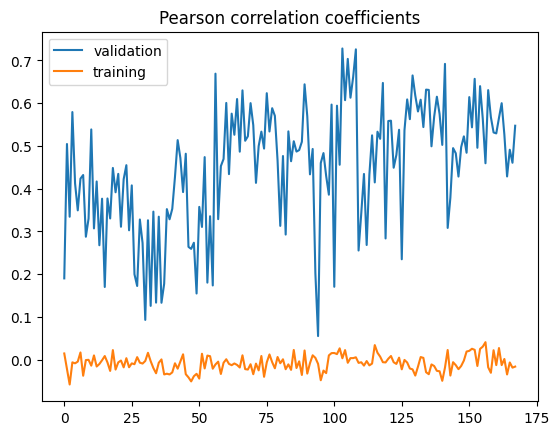

Pearson correlation on training set: -0.008692902090641663
Pearson correlation on validation set: 0.45038755819176923


<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

n_neurons = spikes_train.shape[1]

pearson_corr_shallowcnn = np.zeros((n_neurons,2))
for i in range(n_neurons):
    pearson_corr_shallowcnn[i,0] = np.corrcoef(spikes_train[:, i],prediction_train[:, i])[0, 1]
    pearson_corr_shallowcnn[i,1] = np.corrcoef(spikes_val[:, i],prediction_val[:, i])[0, 1]
plt.figure()
plt.title('Pearson correlation coefficients')
plt.plot(pearson_corr_shallowcnn[:,1], label='validation')
plt.plot(pearson_corr_shallowcnn[:,0], label='training')
plt.legend()
plt.show()
plt.figure()

print(f"Pearson correlation on training set: {np.mean(pearson_corr_shallowcnn[:,0])}")
print(f"Pearson correlation on validation set: {np.mean(pearson_corr_shallowcnn[:,1])}")

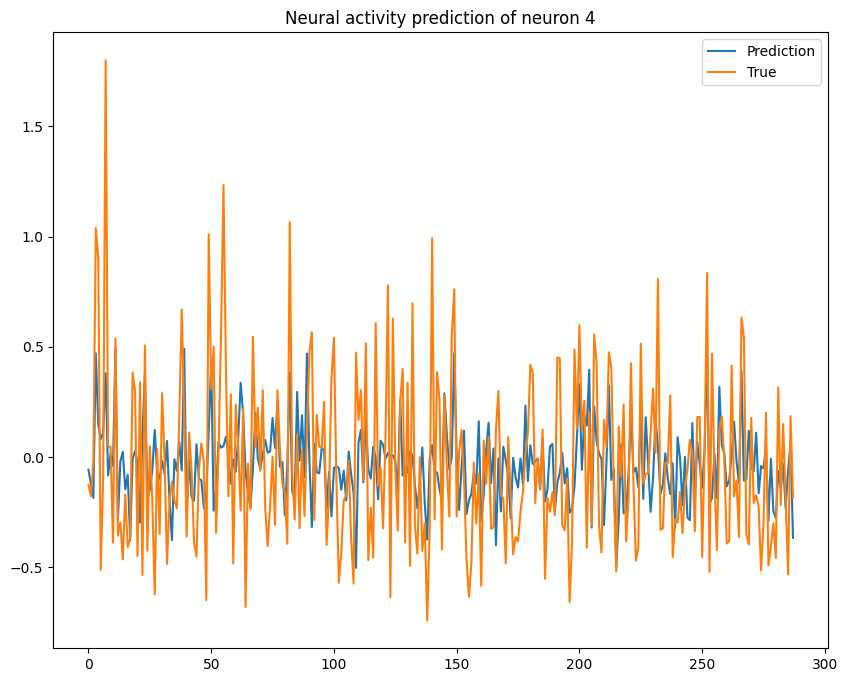

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
example_id = 4

plt.figure(figsize= (10,8))
plt.title(f'Neural activity prediction of neuron {example_id}')
plt.plot(prediction_val[:,example_id], label = "Prediction")
plt.plot(spikes_val[:,example_id], label = "True")
plt.legend()
plt.show()
plt.figure()